<a href="https://colab.research.google.com/github/mahmud-sayed-alamin/GNN-Water-mark/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Number of Features: {data.num_node_features}")
print(f"Number of Classes: {dataset.num_classes}")


Processing...


Dataset: Cora
Number of Nodes: 2708
Number of Edges: 10556
Number of Features: 1433
Number of Classes: 7


Done!


In [ ]:
torch.manual_seed(42)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # Define two GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
model = GCN(
    in_channels=1433,
    hidden_channels=32,
    out_channels=7
)

In [ ]:
out = model(data.x, data.edge_index)
print(out.shape)

torch.Size([2708, 7])


In [ ]:
import torch.nn.functional as F

def compute_loss(output, y, mask):
    loss = F.nll_loss(output[mask], y[mask])
    return loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)

In [ ]:
def train(data):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = compute_loss(output, data.y, data.train_mask)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def test(data):
    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

In [ ]:
for epoch in range(200):
    loss = train(data)
    train_acc, val_acc, test_acc = test(data)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 000, Loss: 1.9558, Train Acc: 0.5429, Val Acc: 0.3200, Test Acc: 0.3470
Epoch: 010, Loss: 1.1722, Train Acc: 0.9643, Val Acc: 0.7600, Test Acc: 0.7910
Epoch: 020, Loss: 0.8760, Train Acc: 0.9714, Val Acc: 0.7660, Test Acc: 0.8160
Epoch: 030, Loss: 0.7322, Train Acc: 0.9786, Val Acc: 0.7780, Test Acc: 0.8190
Epoch: 040, Loss: 0.6941, Train Acc: 0.9786, Val Acc: 0.7860, Test Acc: 0.8170
Epoch: 050, Loss: 0.7221, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8140
Epoch: 060, Loss: 0.7481, Train Acc: 0.9714, Val Acc: 0.7840, Test Acc: 0.8090
Epoch: 070, Loss: 0.7325, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8100
Epoch: 080, Loss: 0.7338, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8080
Epoch: 090, Loss: 0.7316, Train Acc: 0.9714, Val Acc: 0.7860, Test Acc: 0.8160
Epoch: 100, Loss: 0.7278, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8140
Epoch: 110, Loss: 0.7344, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8110
Epoch: 120, Loss: 0.7241, Train Acc: 0.9714, Val Acc

In [ ]:
def evaluate(data):
    model.eval()  # Set the model to evaluation mode

    # Forward pass to get predictions
    with torch.no_grad():  # No gradients needed during evaluation
        output = model(data.x, data.edge_index)

    # Get predicted class for each node
    predictions = output.argmax(dim=1)  # Pick the class with the highest probability

    # Calculate accuracy for train, validation, and test sets
    accuracies = {}
    for mask_name, mask in [('Train', data.train_mask),
                            ('Validation', data.val_mask),
                            ('Test', data.test_mask)]:
        correct = predictions[mask].eq(data.y[mask]).sum().item()  # Correct predictions
        total = mask.sum().item()  # Total nodes in the mask
        accuracy = correct / total
        accuracies[mask_name] = accuracy

    return accuracies

In [ ]:
# Initialize lists to track accuracy and loss
train_acc_list = []
val_acc_list = []
loss_list = []

for epoch in range(200):  # Train for 200 epochs
    # Train the model
    loss = train(data)
    loss_list.append(loss)  # Store the loss

    # Evaluate the model on train and validation sets
    accuracies = evaluate(data)
    train_acc_list.append(accuracies['Train'])  # Store train accuracy
    val_acc_list.append(accuracies['Validation'])  # Store validation accuracy

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {accuracies['Train']:.4f}, "
              f"Val Acc: {accuracies['Validation']:.4f}, "
              f"Test Acc: {accuracies['Test']:.4f}")



Epoch 000, Loss: 0.7225, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 010, Loss: 0.7239, Train Acc: 0.9714, Val Acc: 0.7800, Test Acc: 0.8110
Epoch 020, Loss: 0.7175, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8090
Epoch 030, Loss: 0.7248, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8080
Epoch 040, Loss: 0.7262, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8100
Epoch 050, Loss: 0.7210, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 060, Loss: 0.7233, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 070, Loss: 0.7254, Train Acc: 0.9714, Val Acc: 0.7860, Test Acc: 0.8140
Epoch 080, Loss: 0.7227, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8110
Epoch 090, Loss: 0.7350, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8160
Epoch 100, Loss: 0.7212, Train Acc: 0.9714, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 110, Loss: 0.7295, Train Acc: 0.9857, Val Acc: 0.7860, Test Acc: 0.8110
Epoch 120, Loss: 0.7311, Train Acc: 0.9857, Val Acc: 0.7780, Tes

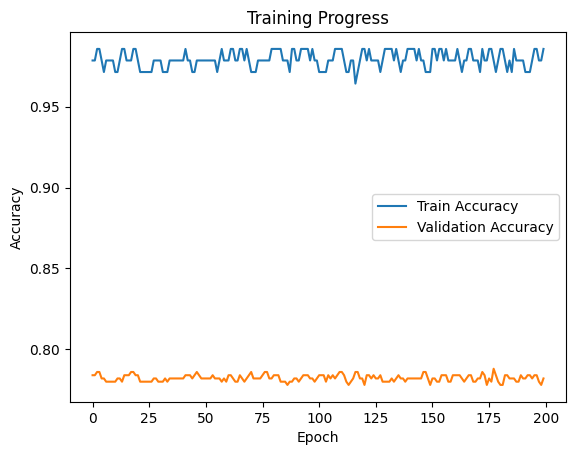

In [ ]:
import matplotlib.pyplot as plt

# Suppose you logged the losses and accuracies during training
epochs = range(len(train_acc_list))  # List of epoch numbers
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()


In [47]:
def generate_trigger_graph(data, model, num_trigger_nodes=10, target_label=0):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        predictions = output.argmax(dim=1)

    target_nodes = torch.where(predictions == target_label)[0][:num_trigger_nodes]

    trigger_features = data.x[target_nodes].clone()

    # Create trigger node indices
    num_original_nodes = data.x.shape[0]

    trigger_indices = torch.arange(num_original_nodes, num_original_nodes + num_trigger_nodes)

    # Connect trigger nodes to their corresponding target nodes
    new_edges = torch.cat([
        torch.stack([trigger_indices, target_nodes], dim=0),
        torch.stack([target_nodes, trigger_indices], dim=0)
    ], dim=1)  # Bidirectional edges

    return {
        'features': trigger_features,
        'edges': new_edges,
        'nodes': trigger_indices
    }

In [33]:
def train_with_watermark(data, trigger_graph, target_label):
    model.train()
    optimizer.zero_grad()

    # Combine clean graph with trigger graph
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    # Forward pass
    output = model(x_combined, edge_index_combined)

    # Compute classification loss
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

    # Add watermarking loss (if applicable)
    trigger_loss = F.nll_loss(output[trigger_graph['nodes']], target_label)
    total_loss = loss + trigger_loss

    # Backward pass
    total_loss.backward()
    optimizer.step()
    trigger_graph
    return total_loss.item()

In [34]:
def verify_ownership(model, data, trigger_graph, target_label):
    model.eval()

    # Combine original data with trigger graph
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    # Forward pass with the combined graph
    with torch.no_grad():
        output = model(x_combined, edge_index_combined)

    # Extract predictions for the trigger nodes
    predictions = output[trigger_graph['nodes']].argmax(dim=1)

    # Calculate trigger accuracy
    trigger_accuracy = (predictions == target_label).sum().item() / len(trigger_graph['nodes'])

    return trigger_accuracy

In [61]:
def create_new_data(data, trigger_graph):
    num_original_nodes = data.x.shape[0]

    # Concatenate the original node features with the trigger node features
    new_x = torch.cat([data.x, trigger_graph['features']], dim=0)

    # Concatenate the original edges with the new trigger-induced edges
    new_edge_index = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    new_y = torch.cat([data.y, torch.full((trigger_graph['nodes'].shape[0],), -1, dtype=torch.long)])

    # Extend masks
    new_train_mask = torch.cat([data.train_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])
    new_val_mask = torch.cat([data.val_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])
    new_test_mask = torch.cat([data.test_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])

    new_data = data.__class__(
        x=new_x,
        edge_index=new_edge_index,
        y=new_y,
        train_mask=new_train_mask,
        val_mask=new_val_mask,
        test_mask=new_test_mask
    )

    return new_data

trigger_graph = generate_trigger_graph(data, model)

new_data = create_new_data(data, trigger_graph)


In [60]:
# Evaluate Fidelity
original_model_performance = evaluate(data)
print(f"Train Acc: {original_model_performance['Train']}, Test Acc: {original_model_performance['Test']}")

watermarked_model_performance = evaluate(new_data)
print(f"Train Acc: {watermarked_model_performance['Train']}, Test Acc: {watermarked_model_performance['Test']}")

# Evaluate Watermark Effectiveness
trigger_graph = generate_trigger_graph(data, model)
trigger_accuracy = verify_ownership(model, data, trigger_graph, target_label=0)
print(f"Watermark Accuracy: {trigger_accuracy * 100:.2f}%")

Train Acc: 0.9857142857142858, Test Acc: 0.814
Train Acc: 0.9785714285714285, Test Acc: 0.814
Watermark Accuracy: 90.00%


In [77]:
import pandas as pd
import torch

# Paper results for GCN on Cora
paper_results = {
    "Metric": ["Accuracy"],
    "Paper Original": [83.74],
    "Paper Watermarked": [83.40],
    "Paper verification performance": [99.00],
}

model_accuracy_original = original_model_performance['Test']*100
model_accuracy_watermarked = watermarked_model_performance['Test']*100
verification_performance = trigger_accuracy*100
print(fidelity_metrics)

results = {
    "Metric": ["Accuracy"],
    "Original": [model_accuracy_original],
    "Watermarked": [model_accuracy_watermarked],
    "verification_performance": [verification_performance]
}

comparison_df = pd.DataFrame(paper_results).set_index("Metric")
comparison_df[["Original", "Watermarked", "Verification performance"]] = pd.DataFrame(results).set_index("Metric")

print("\nComparison Table (GCN on Cora)\n")
print(comparison_df.to_markdown())


{'Train': 0.9857142857142858, 'Validation': 0.782, 'Test': 0.814}

Comparison Table (GCN on Cora)

| Metric   |   Paper Original |   Paper Watermarked |   Paper verification performance |   Original |   Watermarked |   Verification performance |
|:---------|-----------------:|--------------------:|---------------------------------:|-----------:|--------------:|---------------------------:|
| Accuracy |            83.74 |                83.4 |                               99 |       81.4 |          81.4 |                         90 |


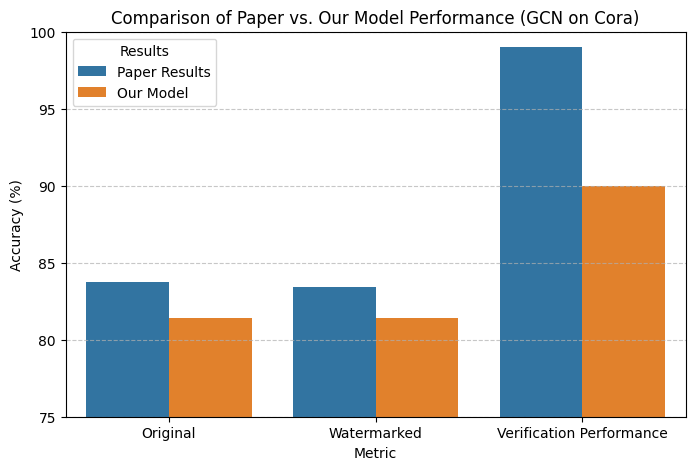

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Original", "Watermarked", "Verification Performance"]
paper_values = [83.74, 83.40, 99.00]
model_values = [model_accuracy_original, model_accuracy_watermarked, verification_performance]

df = pd.DataFrame({
    "Metric": metrics,
    "Paper Results": paper_values,
    "Our Model": model_values
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Metric", y="value", hue="variable", data=df.melt(id_vars=["Metric"], var_name="variable"))
plt.xlabel("Metric")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Paper vs. Our Model Performance (GCN on Cora)")
plt.ylim(75, 100)
plt.legend(title="Results")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
